In [1]:
import pickle 
import numpy as np
import pandas as pd
import pathlib 
import os, sys
import torch 
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt 
from torch.nn import functional as F
import scipy.linalg
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 22

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
%matplotlib widget

In [23]:
with open('/home/kitadam/ENR_Sven/moxie/data/processed/pedestal_profiles_ML_READY_ak_09022022.pickle', 'rb') as file:
    full_dict = pickle.load(file)
    train_X, train_y, train_mask, train_radii, train_ids = full_dict['train_dict']['padded']['profiles'],full_dict['train_dict']['padded']['controls'], full_dict['train_dict']['padded']['masks'], full_dict['train_dict']['padded']['radii'] , full_dict['train_dict']['padded']['pulse_time_ids'] 
    val_X, val_y, val_mask, val_radii, val_ids = full_dict['val_dict']['padded']['profiles'],full_dict['val_dict']['padded']['controls'], full_dict['val_dict']['padded']['masks'], full_dict['val_dict']['padded']['radii'], full_dict['val_dict']['padded']['pulse_time_ids']
    test_X, test_y, test_mask, test_radii, test_ids = full_dict['test_dict']['padded']['profiles'],full_dict['test_dict']['padded']['controls'], full_dict['test_dict']['padded']['masks'], full_dict['test_dict']['padded']['radii'], full_dict['test_dict']['padded']['pulse_time_ids']

train_pulse_order = [int(x.split('/')[0]) for x in train_ids]
train_pulses = list(set(train_pulse_order))
train_pulse_ids = [[index for index in range(len(train_pulse_order)) if train_pulse_order[index] == pulse] for pulse in train_pulses]

val_pulse_order = [int(x.split('/')[0]) for x in val_ids]
val_pulses = list(set(val_pulse_order))
val_pulse_ids = [[index for index in range(len(val_pulse_order)) if val_pulse_order[index] == pulse] for pulse in val_pulses]

test_pulse_order = [int(x.split('/')[0]) for x in test_ids]
test_pulses = list(set(test_pulse_order))
test_pulse_ids = [[index for index in range(len(test_pulse_order)) if test_pulse_order[index] == pulse] for pulse in test_pulses]

machine_param_order = ['Q95', 'RGEO', 'CR0', 'VOLM', 'TRIU', 'TRIL', 'ELON', 'POHM', 'IPLA', 'BVAC', 'NBI', 'ICRH', 'ELER']
jet_pedestal_database = pd.read_csv('/home/kitadam/ENR_Sven/moxie/data/raw/jet-pedestal-database.csv')
jet_pedestal_database = jet_pedestal_database[(jet_pedestal_database['FLAG:HRTSdatavalidated'] > 0) & (jet_pedestal_database['FLAG:DEUTERIUM'] == 1)]
relevant_columns = ['shot', 'nepedheight10^19(m^-3)','Tepedheight(keV)', 'B(T)','Ip(MA)', 'q95',  'R(m)', 'a(m)','gasflowrateofmainspecies10^22(e/s)',  'P_TOT=PNBI+Pohm+PICRH-Pshi(MW)', 'P_ICRH(MW)', 'P_NBI(MW)','plasmavolume(m^3)', 'averagetriangularity', 'divertorconfiguration', 'FLAG:Seeding', 'FLAG:Kicks',
 'FLAG:RMP',
 'FLAG:pellets',]
FLAGS = [x for x in jet_pedestal_database.columns.to_list() if 'FLAG' in x]

In [8]:
experiment_dict =    {
        "TRIANGULARITY":
            {
                "PULSE_LOW": {'id': 82127, 'value': 0.248164},
                "PULSE_HIGH": {'id': 82647, 'value': 0.377240},
                "annotation": {'text': '$q_{95} = 3.2-3.4$\n$I_{P} = 2$ [MA]\n$B_{T} = 2$ [T]\n$P_{abs} = 10$ [MW]\nV/H divertor', 'xy': (0.68,0.70), "xycoords": 'axes fraction', 'size': 'large'},
                "profile_lims": {'PSI_LIM': (0.8, 1.05), 'T_LIM': (-20, 1200)},
                "mp_dim": 4,
                "ls_dims": [0, 1, 2],
                # "ls_dims": [1, 5, 7],
                "latex": '$\delta$'
            },
        "GASPUFF":
            {
                "PULSE_LOW": {'id': 82130, 'value': 1.12e22},
                "PULSE_HIGH": {'id': 81982, 'value': 6.95e22, "subset": [43]},# Because there are two sets of this, so do subset[0]:
                "annotation": {'text': '$q_{95} = 3.2-3.4$\n$I_{P} = 2$ [MA]\n$B_{T} = 2$ [T]\n$P_{abs} = 10$ [MW]\nV/H divertor\n$\delta=0.27$', 'xy': (0.68,0.70), "xycoords": 'axes fraction'},
                "profile_lims": {'PSI_LIM': (0.8, 1.05), 'T_LIM': (-20, 1400)},
                "latex": '$\Gamma$',
                "ls_dims": [1, 4, 6],
                "mp_dim": -1,
            },
        "NBI_POWER":
            {
                "PULSE_LOW": {'id': 83249, 'value': 26.5},
                "PULSE_HIGH": {'id': 83551, 'value': 17.3},
                "annotation": {'text': '$q_{95} = 3$\n$I_{P} = 2.5$ [MA]\n$B_{T} = 2$ [T]\n$\Gamma = 2-2.5$ [e/s]\nV/H divertor\n$\delta=0.28$', 'xy': (0.65,0.70), "xycoords": 'axes fraction', 'size': 'large'},
                "profile_lims": {'PSI_LIM': (0.8, 1.05), 'T_LIM': (-20, 1400)},
                "latex": '$\Gamma$',
                "ls_dims": [4, 5, 6],
                "mp_dim": -3,
            },
        "CURRENT":
            { # [83603, 96517] 86828, 89087
                "PULSE_LOW": {'id': 83603, 'value': 26.5},
                "PULSE_HIGH": {'id': 96517, 'value': 17.3},
                "annotation": {'text': '$q_{95} = 3$\n$I_{P} = 2.5$ [MA]\n$B_{T} = 2$ [T]\n$\Gamma = 2-2.5$ [e/s]\nV/H divertor\n$\delta=0.28$', 'xy': (0.65,0.70), "xycoords": 'axes fraction', 'size': 'large'},
                "profile_lims": {'PSI_LIM': (0.8, 1.05), 'T_LIM': (-20, 1400)},
                "latex": '$I_P$',
                "ls_dims": [2, 4, 5],
                "mp_dim": 8,
            }
    
    
    }

In [26]:
experiment_name = "TRIANGULARITY" # "TRIANGULARITY", "GASPUFF", "NBI_POWER", "CURRENT"
experiment = experiment_dict[experiment_name]
pulse_low_id, pulse_high_id = experiment['PULSE_LOW']['id'], experiment['PULSE_HIGH']['id']
options = [pulse_low_id, pulse_high_id]
mp_dim = experiment['mp_dim']
ls_dims = experiment['ls_dims']

# Plotting stuffs 
annotation = experiment['annotation']
T_LIM, PSI_LIM = experiment['profile_lims']['T_LIM'], experiment['profile_lims']['PSI_LIM']
QUESTION = experiment_name
print(options)

pulse_1_idxs, pulse_2_idxs = [], []
for n, idx in enumerate(train_pulse_order): 
    if idx == options[0]: 
        pulse_1_idxs.append(n)
    elif idx == options[1]: 
        pulse_2_idxs.append(n)

[82127, 82647]


In [25]:
len(train_pulse_ids), len(val_pulse_ids), len(test_pulse_ids)

(1337, 333, 186)

In [80]:
from moxie.models.DIVA_ak_1 import DIVAMODEL
from moxie.data.profile_lightning_module import PLDATAMODULE_AK
from moxie.experiments.DIVA_EXP_AK_1 import EXAMPLE_DIVA_EXP_AK

import pytorch_lightning as pl 
model_hyperparams = {'in_ch': 2, 'out_length':19,
    'mach_latent_dim': 10, 'stoch_latent_dim': 3,
    'beta_stoch': 10e-3,
    'beta_mach':  250., 'alpha_mach': 1.0, 'alpha_prof': 1.0,
    'loss_type': 'semi-supervised'}
model = DIVAMODEL(**model_hyperparams)
model_name = 'REDUCED_PHYSICS_10MD_3SD_1500BMUN_0.002BMSUP_0.1BS_400AM_450AP_128ENCDENSE_50EP_0.01GAMMA'
# model_name = 'REDUCED_SECULAR_10MD_3SD_1500BMUN_0.001BMSUP_0.1BS_400AM_400AP_128ENCDENSE_50EP'
model_name = 'REDUCED_PHYSICS_10MD_3SD_100BMUN_0.003BMSUP_0.1BS_400AM_1000AP_128ENCDENSE_50EP_0.1GAMMA'
state_dict = torch.load('./model_results/modelstatedict_{}.pth'.format(model_name))
model.load_state_dict(state_dict['model'])

<All keys matched successfully>

In [92]:
# Helper Functions
def de_standardize(x, mu, var): 
    return (x*var) + mu

def standardize(x, mu, var): 
    return (x - mu) / var

def get_preds_pulse(PULSE): 
    X, PSI, MASK, ID, MPS = PULSE
    X[:, 0] = standardize(X[:, 0], D_norm, D_var)
    X[:, 1] = standardize(X[:, 1], T_norm, T_var)

    with torch.no_grad(): 
        # Get encoder prediction of X 
        mu_stoch, log_var_stoch, mu_mach, log_var_mach = model.q_zy(X)
        z_stoch, z_mach = model.reparameterize(mu_stoch, log_var_stoch), model.reparameterize(mu_mach, log_var_mach)
        z_encoder = torch.cat((z_stoch, z_mach), 1)
        
        out_profs_enc = model.p_yhatz(z_encoder)
        out_mp_enc = model.q_hatxzmach(z_mach)
    
    X[:, 0] = de_standardize(X[:, 0], D_norm, D_var)
    X[:, 1] = de_standardize(X[:, 1], T_norm, T_var)
    out_profs_enc[:, 0] = de_standardize(out_profs_enc[:, 0], D_norm, D_var)
    out_profs_enc[:, 1] = de_standardize(out_profs_enc[:, 1], T_norm, T_var)
    return out_profs_enc, out_mp_enc
    
def get_conditional_preds(PULSE, n_samples=100): 
    X, PSI, MASK, ID, MPS = PULSE
    X[:, 0] = standardize(X[:, 0], D_norm, D_var)
    X[:, 1] = standardize(X[:, 1], T_norm, T_var)
    MPS = standardize(MPS, MP_norm, MP_var)
    out_profs_cond_all = torch.zeros((n_samples, X.shape[0], X.shape[1], X.shape[2]))
    with torch.no_grad():         
        cond_mu, cond_var =  model.p_zmachx(MPS)
        z_mach = model.reparameterize(cond_mu, cond_var)
        mu_stoch, log_var_stoch, mu_mach, log_var_mach = model.q_zy(X)
        # z_stoch = model.reparameterize(mu_stoch, log_var_stoch)
        z_stoch = mu_stoch
        z_mach = cond_mu
        z_conditional = torch.cat((z_stoch, z_mach), 1)
        out_profs_cond = model.p_yhatz(z_conditional)
    out_profs_cond[:, 0] = de_standardize(out_profs_cond[:, 0], D_norm, D_var)
    out_profs_cond[:, 1] = de_standardize(out_profs_cond[:, 1], T_norm, T_var)
        
    """
    for i in range(n_samples): 
        with torch.no_grad():         
            z_stoch = torch.distributions.normal.Normal(0,1).sample((z_mach.shape[0], 3))
            z_conditional = torch.cat((z_stoch, z_mach), 1)
            
            out_profs_cond = model.p_yhatz(z_conditional)
        
        out_profs_cond[:, 0] = de_standardize(out_profs_cond[:, 0], D_norm, D_var)
        out_profs_cond[:, 1] = de_standardize(out_profs_cond[:, 1], T_norm, T_var)
        
        out_profs_cond_all[i] = out_profs_cond
    """
    MPS = de_standardize(MPS, MP_norm, MP_var)
    X[:, 0] = de_standardize(X[:, 0], D_norm, D_var)
    X[:, 1] = de_standardize(X[:, 1], T_norm, T_var)
    
    return out_profs_cond
    
    
    # Conditional prediction of X 
    
    # MP predictions of X from enc
    
    # MP prediction of X from cond

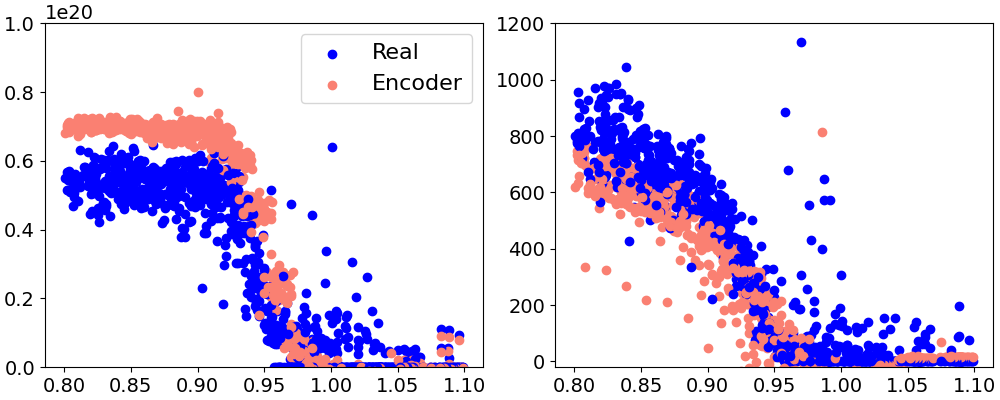

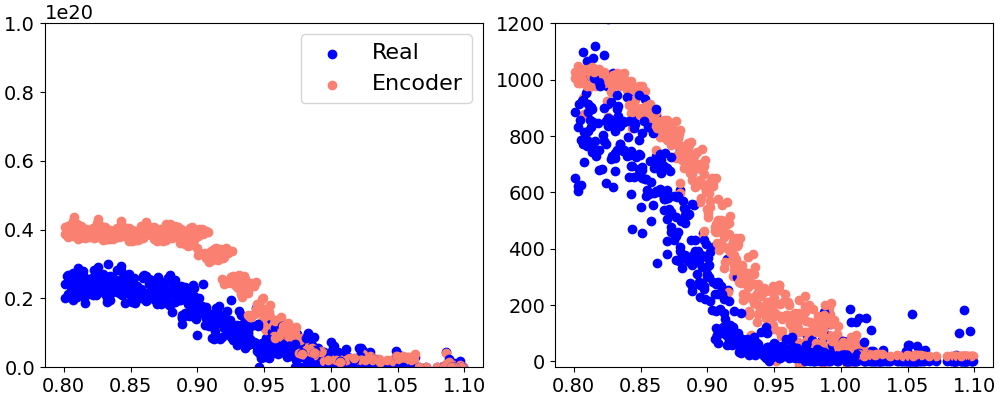

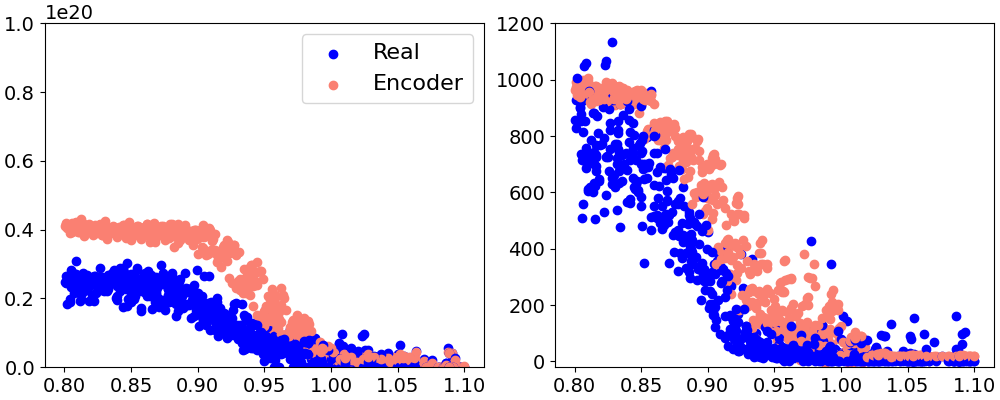

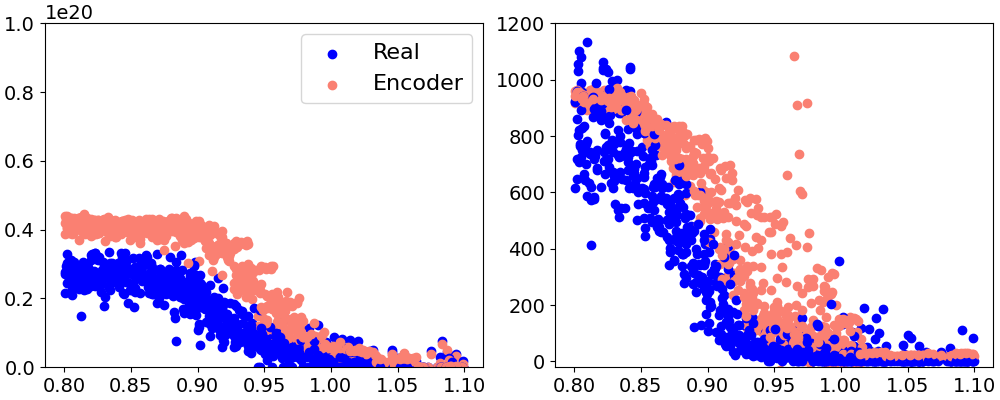

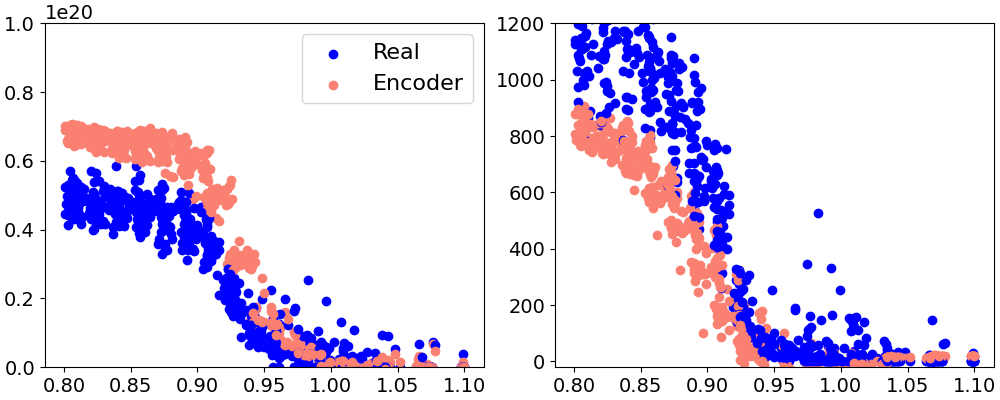

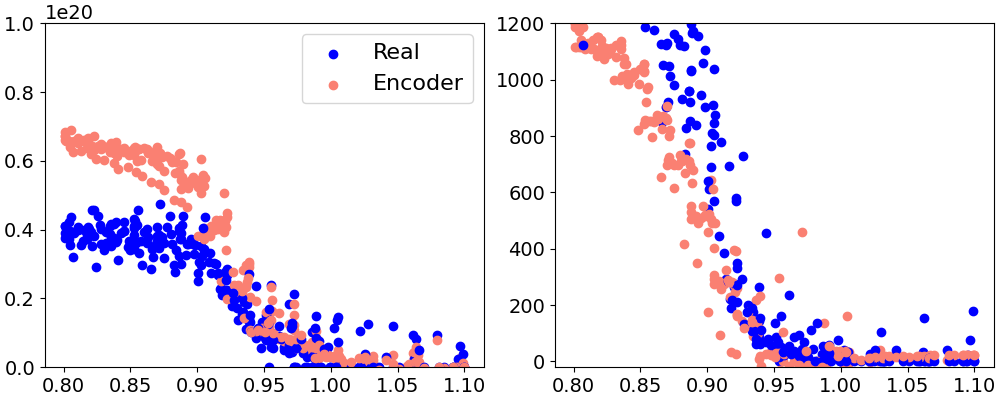

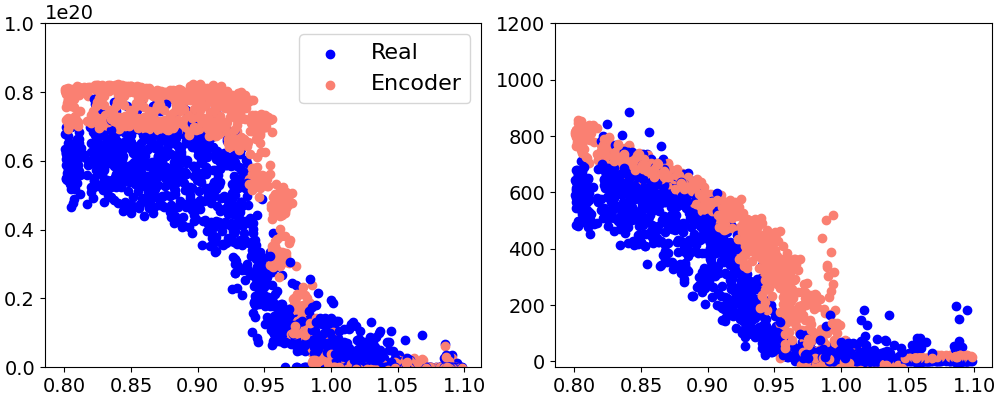

In [93]:

# Things that don't change after training 
MP_norm, MP_var = state_dict['MP_norms']
norms_MP = MP_norm, MP_var
D_norm, D_var = state_dict['D_norms']
norms_D = D_norm, D_var
T_norm, T_var = state_dict['T_norms']
norms_T = T_norm, T_var


# Training Tensors 

train_mp_tensors = torch.tensor(train_y).float()
val_mp_tensors = torch.tensor(val_y).float()

train_mp_normalized = standardize(train_mp_tensors, MP_norm, MP_var)
test_mp_tensors = torch.tensor(test_y).float()
test_mp_normalized = standardize(test_mp_tensors, MP_norm, MP_var)

train_profiles = torch.tensor(train_X).float()
val_profiles = torch.tensor(val_X).float()

train_profiles_normalized = torch.clone(train_profiles).float()
train_profiles_normalized[:, 0] = standardize(train_profiles_normalized[:, 0], D_norm, D_var)
train_profiles_normalized[:, 1] = standardize(train_profiles_normalized[:, 1], T_norm, T_var)


test_profiles = torch.tensor(test_X).float()

test_profiles_normalized = torch.clone(test_profiles).float()
test_profiles_normalized[:, 0] = standardize(test_profiles_normalized[:, 0], D_norm, D_var)
test_profiles_normalized[:, 1] = standardize(test_profiles_normalized[:, 1], T_norm, T_var)

k = 13 # 12, 19, 29, 35, 36

PULSE_1_real = train_profiles[pulse_1_idxs], train_radii[pulse_1_idxs], train_mask[pulse_1_idxs] > 0, options[0], train_mp_tensors[pulse_1_idxs]
PULSE_2_real = train_profiles[pulse_2_idxs], train_radii[pulse_2_idxs], train_mask[pulse_2_idxs] > 0, options[1], train_mp_tensors[pulse_2_idxs]

PULSE_1_profs_conditional = get_conditional_preds(PULSE_1_real, n_samples=200)
PULSE_1_profs_encoder, PULSE_1_mps_encoder = get_preds_pulse(PULSE_1_real)

PULSE_2_profs_conditional = get_conditional_preds(PULSE_2_real, n_samples=200)
PULSE_2_profs_encoder, PULSE_2_mps_encoder = get_preds_pulse(PULSE_2_real)



plt.close('all')
for k in [41, 42, 43, 44, 45, 46, 47]: 
    PULSE_val_1_real = val_profiles[val_pulse_ids[k]], val_radii[val_pulse_ids[k]], val_mask[val_pulse_ids[k]] > 0, val_pulses[k], val_mp_tensors[val_pulse_ids[k]]
    PULSE_val_conditional = get_conditional_preds(PULSE_val_1_real, n_samples=200)
    plot_profiles(PULSE_val_1_real[0], PULSE_val_1_real[1], PULSE_val_1_real[2],PULSE_val_conditional, plot_params={'annotation': None, 'id': PULSE_val_1_real[3], 'title': 'Valid', 'TLIM': (-200, 3000)})
    

# Z_MACH_TRAINING, Z_STOCH_TRAINING, Z_TRAINING = get_latent_space(train_profiles_normalized, model)
# PRED_MPS_FROM_Z_TRAINING_NORM, PRED_MPS_FROM_Z_TRAINING_REAL = get_mps(Z_MACH_TRAINING, model)

# Z_MACH_TRAINING_no_physics, Z_STOCH_TRAINING_no_physics, Z_TRAINING_no_physics = get_latent_space(train_profiles_normalized, model_no_physics)
# PRED_MPS_FROM_Z_TRAINING_NORM_no_physics, PRED_MPS_FROM_Z_TRAINING_REAL_no_physics = get_mps(Z_MACH_TRAINING, model_no_physics)

KeyError: 'TLIM'

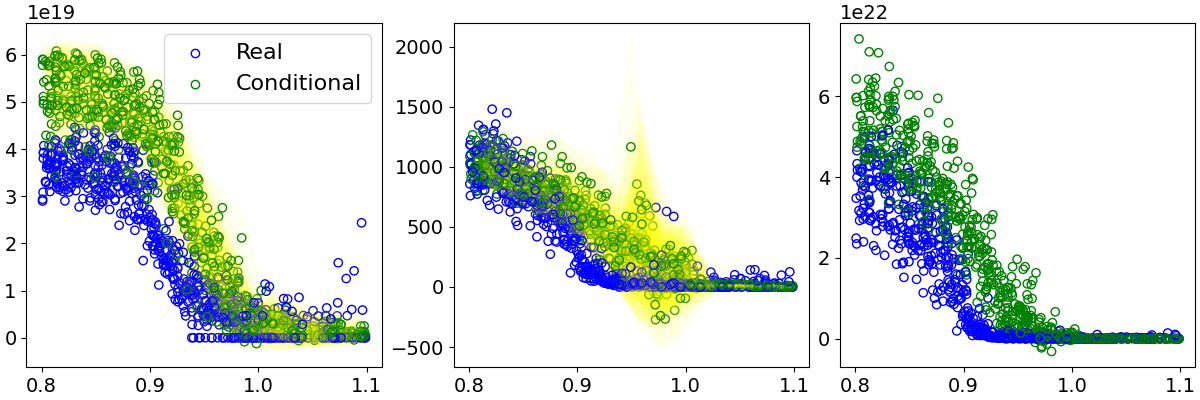

In [57]:



plt.close('all')
def plot_conditional(profiles_real, radii, masks, profiles_cond, plot_params={'title': '', 'id': 0}): 
    d_profs_real, t_profs_real = profiles_real[:, 0, :], profiles_real[:, 1, :]
    d_profs_cond, t_profs_cond = profiles_cond[:, :, 0, :], profiles_cond[:, :, 1, :]
    
    fig, axs = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)
    """
    i = 0
    for sample_d, sample_t in zip(d_profs_cond, t_profs_cond): 
        for prof_d, prof_t, rad, mask in zip(sample_d, sample_t, radii, masks,): 
            if i == 0: 
                label = 'all conditonal'
                i += 1
            else: 
                label=None
            axs[0].scatter(rad[mask], prof_d[mask], c='black', label=label)
            axs[1].scatter(rad[mask], prof_t[mask], c='black')
        
    """
    for n, (d_prof_real, t_prof_real, rad, mask, averaged_d, std_d, averaged_t, std_t) in enumerate(zip(d_profs_real, t_profs_real, radii, masks, torch.mean(d_profs_cond, 0), torch.std(d_profs_cond, 0), torch.mean(t_profs_cond, 0), torch.std(t_profs_cond, 0))): 
        
        
        axs[0].scatter(rad[mask], d_prof_real[mask], facecolors='none', edgecolors='blue', label='Real')
        axs[1].scatter(rad[mask], t_prof_real[mask], facecolors='none', edgecolors='blue', label='Real')
        axs[2].scatter(rad[mask], t_prof_real[mask]*d_prof_real[mask], facecolors='none', edgecolors='blue', label='Real')
        
        axs[0].scatter(rad[mask], averaged_d[mask], facecolors='none', edgecolors='green', label='Conditional')
        axs[0].fill_between(rad[mask], averaged_d[mask] + std_d[mask], averaged_d[mask] - std_d[mask], color='yellow', alpha=0.05)
        # axs[0].scatter(rad[mask], averaged_d[mask] - std_d[mask], c='yellow', alpha=0.1)
        
        axs[1].scatter(rad[mask], averaged_t[mask], facecolors='none', edgecolors='green',)
        axs[1].fill_between(rad[mask], averaged_t[mask] + std_t[mask], averaged_t[mask] - std_t[mask], color='yellow', alpha=0.05)
        
        axs[2].scatter(rad[mask], averaged_d[mask]*averaged_t[mask], facecolors='none', edgecolors='green',)
        # axs[2].fill_between(rad[mask], averaged_t[mask] + std_t[mask], averaged_t[mask] - std_t[mask], color='yellow', alpha=0.05)
        
        # axs[1].scatter(rad[mask], averaged_t[mask] - std_t[mask], c='yellow', alpha=0.1)
        
        if n == 0: 
            axs[0].legend()
    axs[1].set_ylim(plot_params['TLIM'])
    axs[0].set_ylim(-5e18, 1e20)
    plt.suptitle(plot_params['title'] + ': Shot ' + str(plot_params['id']))
    plt.show()
plot_conditional(PULSE_val_1_real[0], PULSE_val_1_real[1], PULSE_val_1_real[2],PULSE_val_conditional, plot_params={'annotation': None, 'id': PULSE_val_1_real[3], 'title': 'Valid'})
# plot_conditional(PULSE_1_real[0], PULSE_1_real[1], PULSE_1_real[2],PULSE_1_profs_conditional)
# plot_conditional(PULSE_2_real[0], PULSE_2_real[1], PULSE_2_real[2],PULSE_2_profs_conditional)



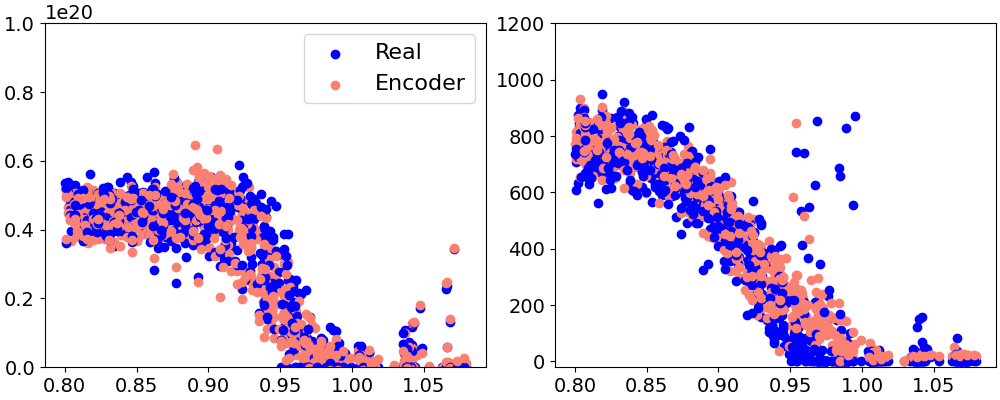

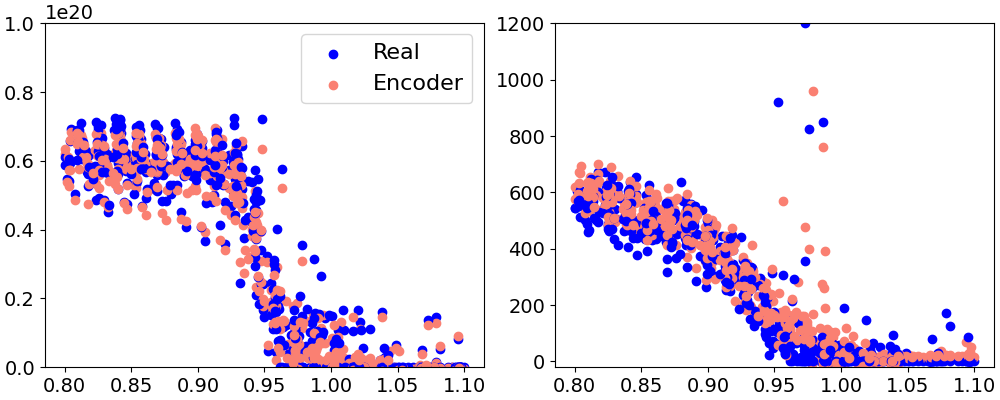

In [83]:
plt.close('all')
# Compare from encoder and real 
def plot_profiles(profiles_real, radii, masks, profiles_enc, plot_params={}):
    d_profs_real, t_profs_real = profiles_real[:, 0, :], profiles_real[:, 1, :]
    d_profs_enc, t_profs_enc = profiles_enc[:, 0, :], profiles_enc[:, 1, :]

    fig, axs = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
    for n, (d_prof_real, t_prof_real, rad, mask, d_prof_enc, t_prof_enc) in enumerate(zip(d_profs_real, t_profs_real, radii, masks, d_profs_enc, t_profs_enc)): 
        
        axs[0].scatter(rad[mask], d_prof_real[mask], c='blue', label='Real')
        axs[1].scatter(rad[mask], t_prof_real[mask], c='blue')
        
        axs[0].scatter(rad[mask], d_prof_enc[mask], c='salmon', label='Encoder')
        axs[1].scatter(rad[mask], t_prof_enc[mask], c='salmon')
        
        
        if n == 0: 
            axs[0].legend()
    axs[1].set_ylim(T_LIM)
    axs[0].set_ylim(0, 1e20)
    plt.show()
    
plot_profiles(PULSE_1_real[0], PULSE_1_real[1], PULSE_1_real[2],PULSE_1_profs_encoder )
plot_profiles(PULSE_2_real[0], PULSE_2_real[1], PULSE_2_real[2],PULSE_2_profs_encoder )

tensor([[[-0.0831, -0.0829, -0.0814,  ..., -0.6201, -0.4864, -0.3899],
         [-0.4397, -0.4392, -0.4300,  ..., -0.1769, -0.1819, -0.1894]],

        [[-0.0817, -0.0815, -0.0800,  ..., -0.6201, -0.4864, -0.3899],
         [ 0.1139,  0.1142,  0.1208,  ..., -0.1769, -0.1819, -0.1894]],

        [[ 0.1562,  0.1563,  0.1579,  ...,  0.6316, -0.4864, -0.3899],
         [ 0.4293,  0.4295,  0.4346,  ...,  0.3395, -0.1819, -0.1894]],

        ...,

        [[-0.4654, -0.4653, -0.4639,  ..., -0.6201,  0.8378, -0.3899],
         [ 0.5831,  0.5833,  0.5877,  ..., -0.1769,  0.6485, -0.1894]],

        [[-0.6800, -0.6799, -0.6786,  ..., -0.6201, -0.4864, -0.3899],
         [ 0.0269,  0.0273,  0.0343,  ..., -0.1769, -0.1819, -0.1894]],

        [[-0.6259, -0.6258, -0.6244,  ..., -0.6201, -0.4864, -0.3899],
         [-0.2312, -0.2307, -0.2225,  ..., -0.1769, -0.1819, -0.1894]]])